<a href="https://colab.research.google.com/github/ons-ou/Image_Recommendation/blob/main/ImageRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Downloading the dataset


In [ ]:
! pip install swifter
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! sudo chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=9f4cb977fadffb3b26b1c252aa4ab38d6290d14105ec50c6750f5049d5c0212f
  Stored in directory: /root/.cache/pip/wheels/6c/bd/3e/2d6afc9bc36c9975f8e4215a270bbac6580c4361ebd6bb2323
Successfully built swifter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download -d paramaggarwal/fashion-product-images-small

 99% 557M/565M [00:04<00:00, 90.3MB/s]
100% 565M/565M [00:04<00:00, 125MB/s] 


In [ ]:
! unzip fashion-product-images-small

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

# Data Preparation

###**Imports and Constants**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets.folder import pil_loader
import cv2
from PIL import Image
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(17)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
print(torch.cuda.device_count())

0


In [ ]:
DATASET_PATH = "/content/myntradataset/"
print(os.listdir(DATASET_PATH))

batch_size = 32

['styles.csv', 'images']


###**Declaring the dataset**


> Declaring the dataframe



In [ ]:
df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines="skip")
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


<Axes: >

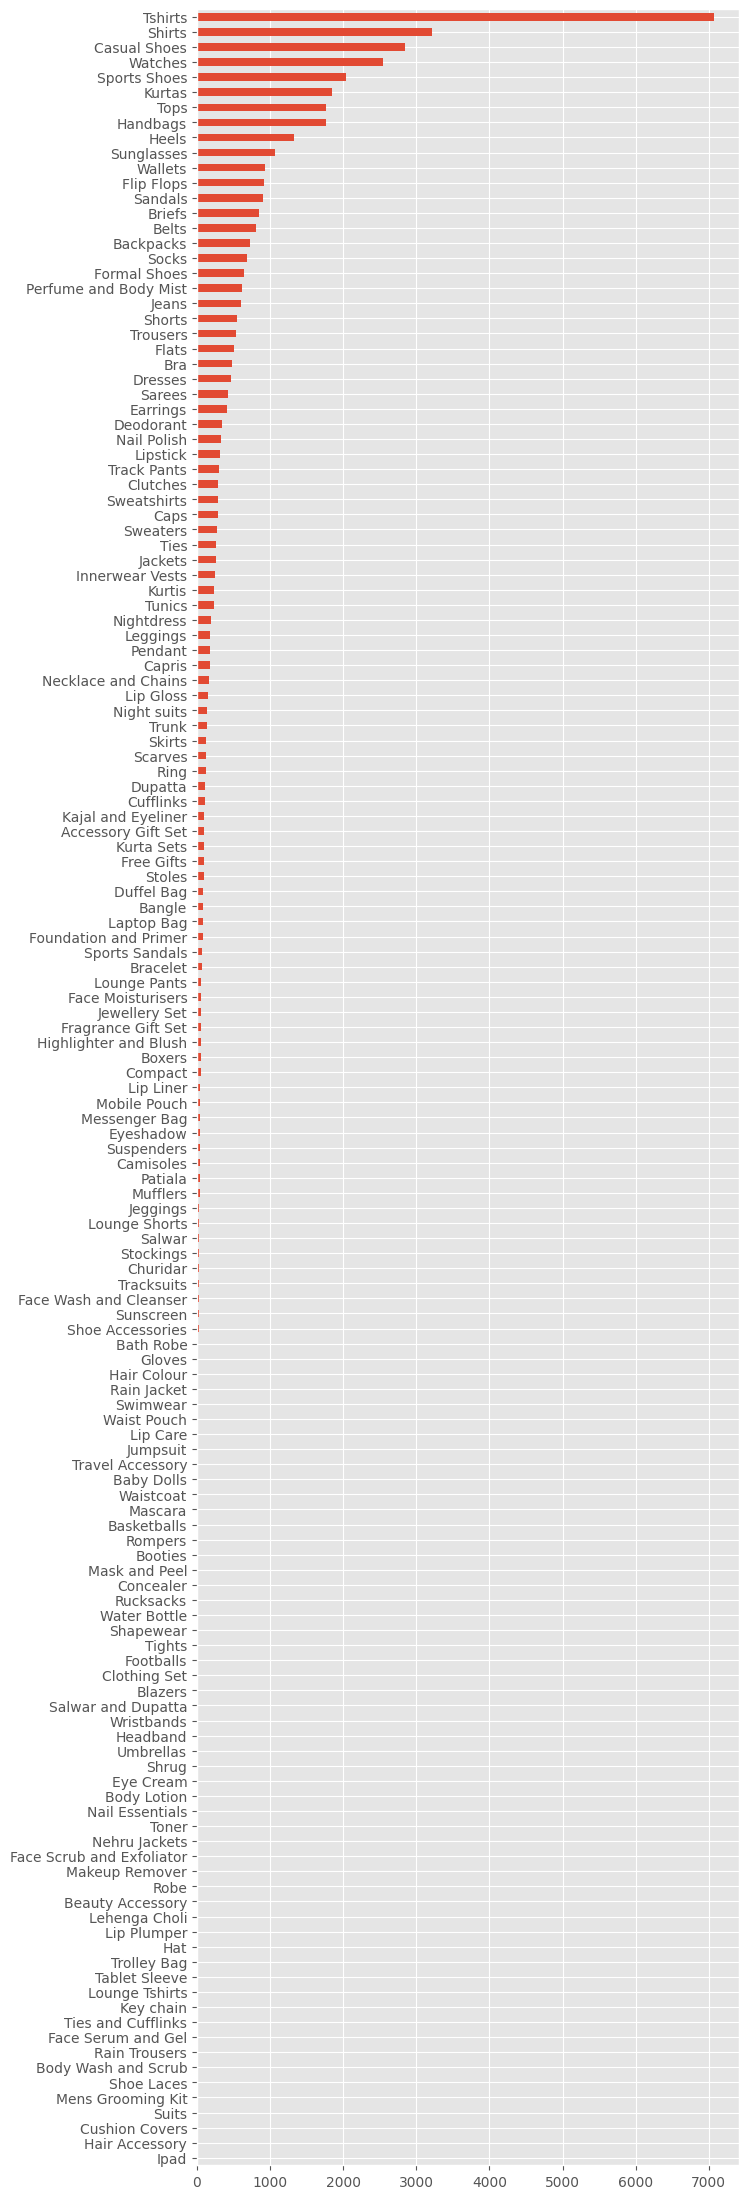

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

> Removing missing images



In [ ]:
for item in df.iloc: 
    try:
        Image.open("/content/images/" + str(item[0]) + ".jpg")
    except:
        df.drop(df[df['id'] == item[0]].index, inplace=True)
        print("Deleted element " + str(item[0]))

Deleted element 39403
Deleted element 39410
Deleted element 39401
Deleted element 39425
Deleted element 12347


> Dataset class



In [ ]:
class FashionDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.data = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_id = str(self.data.iloc[index, 0])
        image_path = self.image_folder + '/' + image_id + ".jpg"
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image).unsqueeze(0)
        return  image

    def show_image(self, index, ax=None):
        info = [self.data.iloc[index, 0], self.data.iloc[index, 9]]
        image_id = self.data.iloc[index, 0]
        image_path = self.image_folder + '/' + str(self.data.iloc[index, 0]) + ".jpg"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if ax is None:
            plt.imshow(image)
            plt.title('{}: {}'.format(info[0], info[1]))
            plt.show()
        else:
            ax.imshow(image)
            ax.set_title('{}: {}'.format(info[0], info[1]))

> Initialization





In [ ]:
# Define data transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1])
])

# Initialize custom dataset object
dataset = FashionDataset(df[:5000], '/content/images', transform=transform)

> Visualizing images



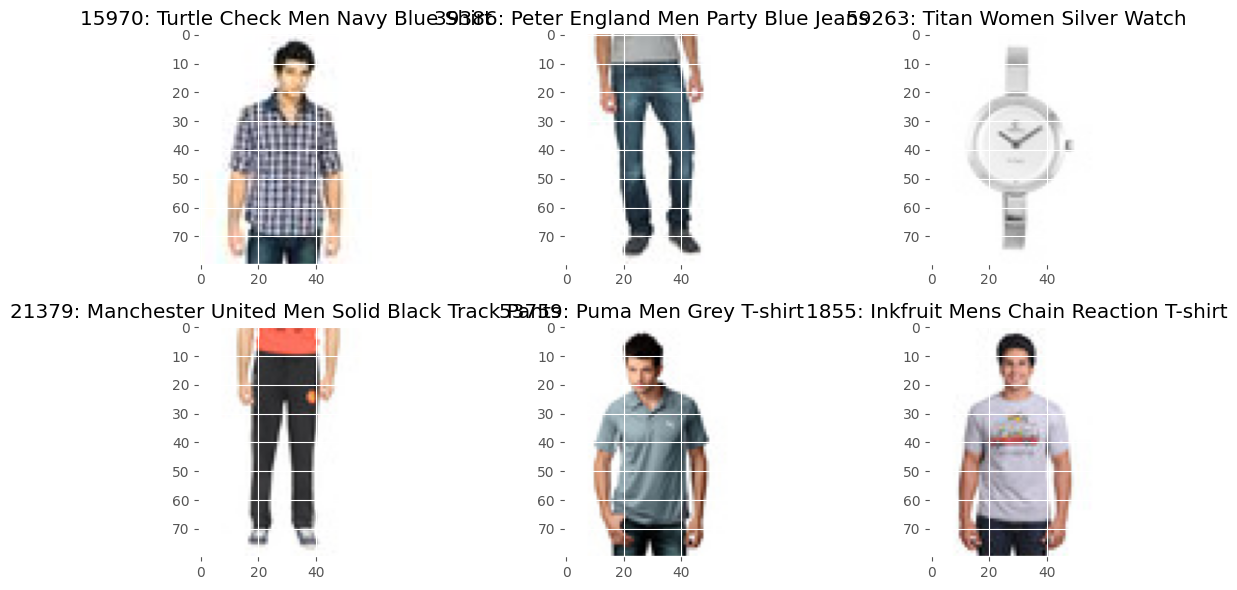

In [ ]:
def show_images(lst, cols=3):
    rows = len(lst) // cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i in range(len(lst)):
        if lst[i] < len(dataset):
            row_idx = i // cols 
            col_idx = i % cols
            if row_idx < rows and col_idx < cols:  # check if row_idx and col_idx are valid indices for axes
                dataset.show_image(lst[i], ax=axes[row_idx, col_idx])
            else:
                print(f"Invalid indices ({row_idx}, {col_idx}) for axes.")
        else:
            print(f"Invalid index value {lst[i]} for dataset.")
    
    plt.tight_layout()
    plt.show()

show_images([0, 1, 2, 3, 4, 5])

#Calculating Similarities

###**Imports and Constants**

In [ ]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics.pairwise import cosine_similarity, csr_matrix

###**Converting images to embeddings**

> Resnet18 model


In [ ]:
resnet18 = models.resnet18(pretrained=True)
layers = list(resnet18.children())[:-1]
new_model = nn.Sequential(*layers)
new_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.6MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con


> Vector Extraction




In [ ]:
def vector_extraction(image):
    embeddings= torch.zeros(512)
    
    def select_d(m,i,o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
    
    hlayer = new_model.register_forward_hook(select_d)
    new_model(image)
    hlayer.remove()
    emb = embeddings
    return embeddings



> Testing vector extraction on two images



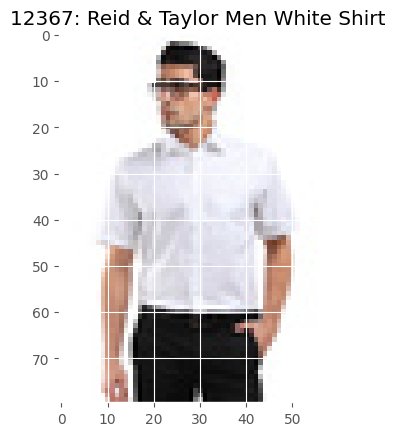

In [ ]:
image = dataset[1000]
sample_embedding_0 = vector_extraction(image)
dataset.show_image(1000)

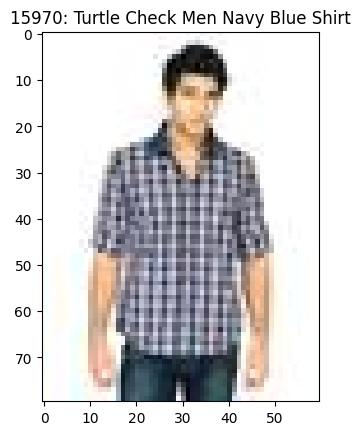

In [ ]:
image = dataset[0]
sample_embedding_1 = vector_extraction(image)
dataset.show_image(0)

In [ ]:
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))
print(cos_sim)


[[0.8628776]]




> Turning All images to embeddings



In [ ]:
embeddings = [vector_extraction(image).unsqueeze(0) for image in dataset]

In [ ]:
np.save("/content/drive/My Drive/embeddings.npy", embeddings)
embeddings_tensor = torch.cat(embeddings, dim = 0)

### **Image Recommendation**





> Calculating Similarities



In [ ]:
import numpy as np
embeddings = np.load('/content/drive/My Drive/embeddings.npy', allow_pickle=True)
embeddings_array = np.concatenate(embeddings, axis=0)
embeddings_tensor = torch.from_numpy(embeddings_array)

In [ ]:
similarity_matrix = cosine_similarity(embeddings_tensor, dense_output=False)



> Recommend images



In [ ]:
def get_recommendations(i,df,top_n=6):
  sml_scr=list(enumerate(similarity_matrix[i]))
  sml_scr=sorted(sml_scr,key=lambda x:x[1],reverse=True)
  sml_scr=sml_scr[1:top_n+1]
  ImId_rec=[j[0] for j in sml_scr]
  ImId_sim=[j[1] for j in sml_scr]
  return ImId_rec, ImId_sim

get_recommendations(3810, dataset)        

([0, 3899, 3678, 634, 4746, 659],
 [0.9671673, 0.96288824, 0.95623326, 0.95565593, 0.9534767, 0.95190823])

[1543, 3694, 2268, 1086, 2346, 1815] [0.930105, 0.92684615, 0.92666733, 0.9216466, 0.9213674, 0.91960204]


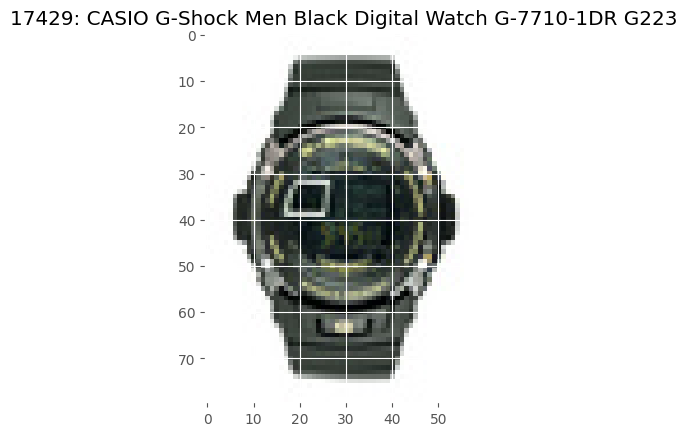

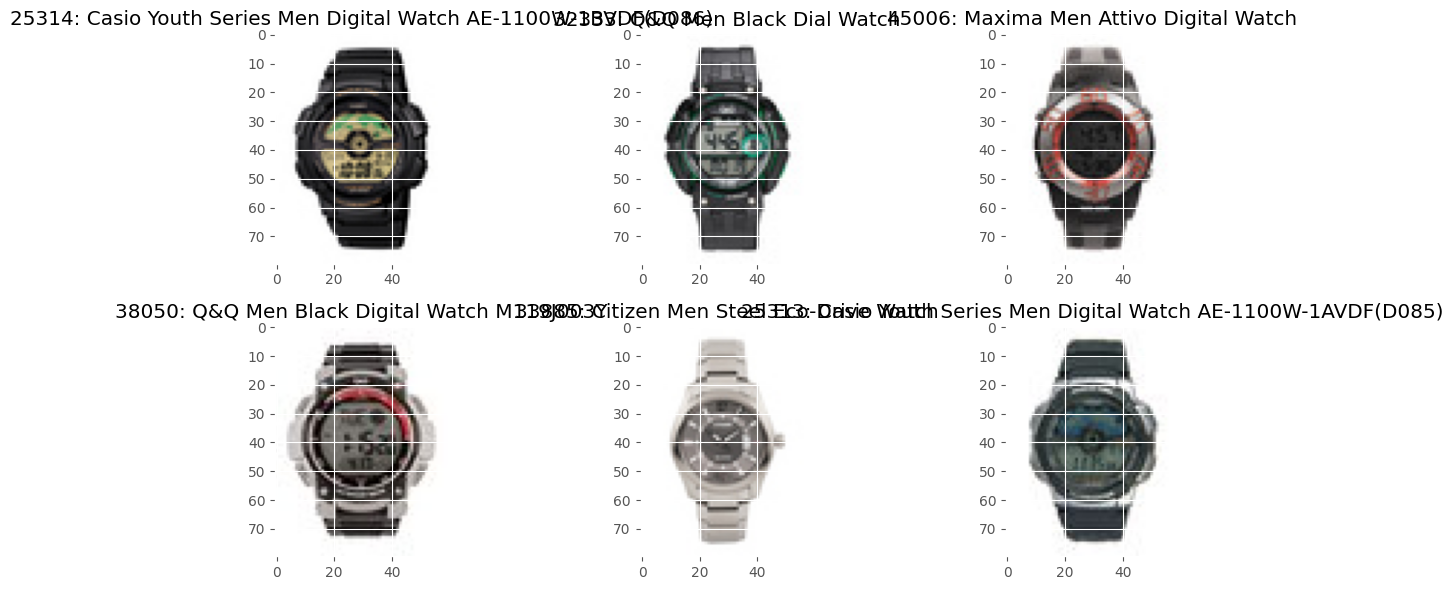

In [ ]:
def visualisation(id):
  idx_rec, sim=get_recommendations(id, df,top_n=6)
  print(idx_rec,sim)
  dataset.show_image(id)
  show_images(idx_rec)

visualisation(20)

#Recommending from user input




> Importing an image



In [ ]:
def import_image(image_path):
    image = pil_loader(image_path)
    image = transform(image)
    return  image



> Displaying an image



In [ ]:
def show_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()



> Finding recommendations by user input



In [ ]:
def recm_user_input(image_path, top_n = 6):
  image = import_image(image_path)
  emb = vector_extraction(image.unsqueeze(0))
  s = [(cosine_similarity(emb.unsqueeze(0), embeddings_tensor[i].unsqueeze(0)), i) for i in range(len(embeddings_tensor))]
  s=sorted(s,key=lambda x:x[0],reverse=True)
  s=s[:top_n]
  top_image_ids = [i for _, i in s]
  print(top_image_ids)
  print()
  print("Uploaded Image: ")
  show_image(image_path)
  print()
  print("Image search results:")
  show_images(top_image_ids)

In [ ]:
from google.colab import files

print("----------------------------------------------------------------------------------Image Recommendation------------------------------------------------------------------------------------------------")
print()
print("Upload an image: ")
uploaded = files.upload()
print()
# Get the name of the uploaded file
filename = next(iter(uploaded))
print("Uploaded file name:", filename)

recm_user_input("/content/" + filename)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


----------------------------------------------------------------------------------Image Recommendation------------------------------------------------------------------------------------------------

Upload an image: 


Saving images (1).jpeg to images (1) (1).jpeg

Uploaded file name: images (1).jpeg


NameError: ignored